In [1]:
import pandas as pd
import numpy as np
import os,csv
import matplotlib.pyplot as plt
import seaborn as sns
import os,cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization,Input
from keras.preprocessing import image as f_image
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

2025-01-09 08:26:58.081950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736411218.097869  406154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736411218.102783  406154 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 08:26:58.119511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path_data_train="data/train/"
path_data_test="data/test/"

In [3]:
data=[]

In [4]:
for folder in os.listdir(path_data_train):
    folder_path=os.path.join(path_data_train,folder)
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            image_path=os.path.join(folder_path,image)
            if image.endswith(('.png','.jpg')):
                data.append({
                    "path":image_path,
                    "label":folder
                })

In [5]:
df=pd.DataFrame(data)
df.to_csv("data/mapping_label.csv",index=False,header=True)
df

,path,label
0,data/train/angry/Training_10118481.jpg,angry
1,data/train/angry/Training_10120469.jpg,angry
2,data/train/angry/Training_10131352.jpg,angry
3,data/train/angry/Training_10161559.jpg,angry
4,data/train/angry/Training_1021836.jpg,angry
...,...,...
28704,data/train/surprise/Training_99916297.jpg,surprise
28705,data/train/surprise/Training_99924420.jpg,surprise
28706,data/train/surprise/Training_99937001.jpg,surprise
28707,data/train/surprise/Training_99951755.jpg,surprise


In [6]:
name_duplicated=df.duplicated(subset=['path']).sum()
name_duplicated

0

In [7]:
# randomize
df=df.sample(frac=1,random_state=42).reset_index(drop=True)
df

,path,label
0,data/train/fear/Training_22695598.jpg,fear
1,data/train/happy/Training_47178464.jpg,happy
2,data/train/surprise/Training_76747047.jpg,surprise
3,data/train/fear/Training_22757966.jpg,fear
4,data/train/surprise/Training_78696030.jpg,surprise
...,...,...
28704,data/train/sad/Training_25755162.jpg,sad
28705,data/train/fear/Training_31740082.jpg,fear
28706,data/train/angry/Training_29393434.jpg,angry
28707,data/train/neutral/Training_10904555.jpg,neutral


In [8]:
df.describe()

,path,label
count,28709,28709
unique,28709,7
top,data/train/fear/Training_22695598.jpg,happy
freq,1,7215


In [9]:
labels_count=df['label'].value_counts()
labels_count

label
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

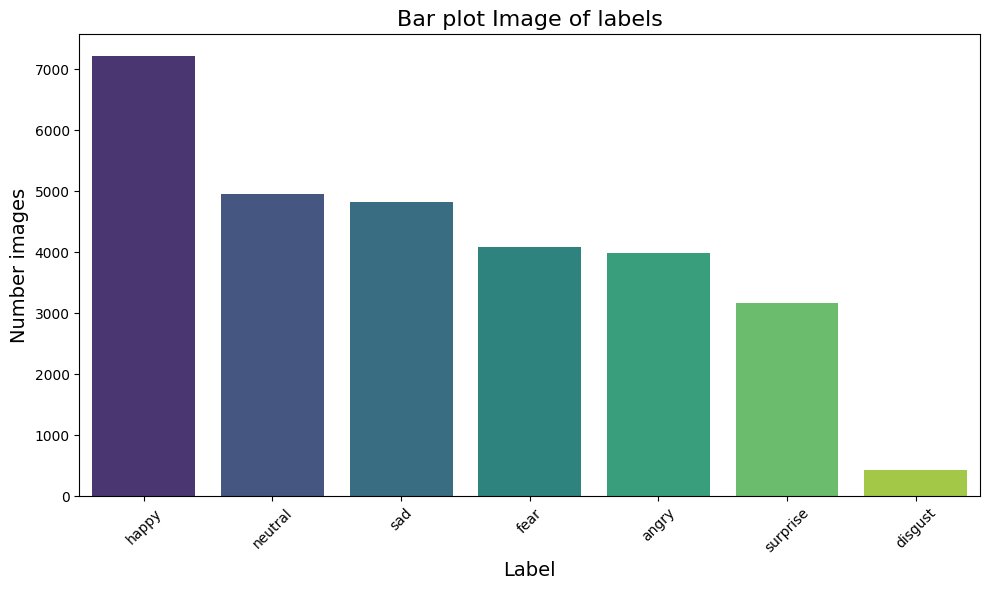

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=labels_count.index, y=labels_count.values, palette="viridis")
plt.title("Bar plot Image of labels", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Number images", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

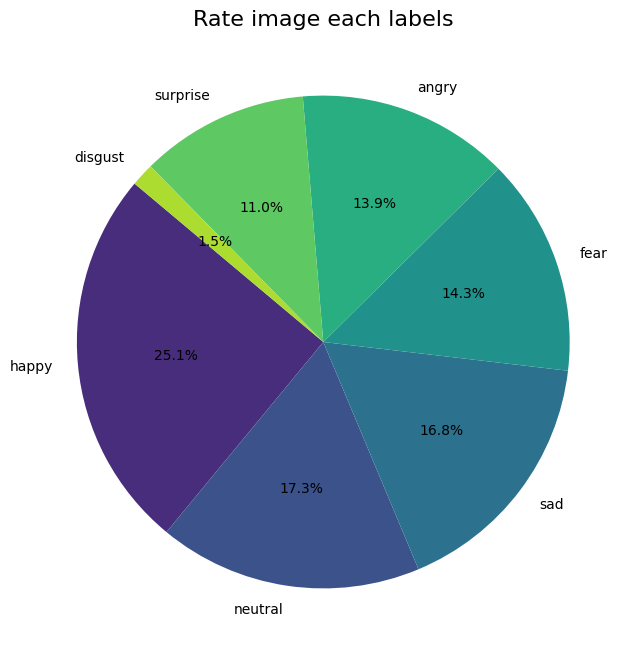

In [11]:
plt.figure(figsize=(8, 8))
plt.pie(labels_count, labels=labels_count.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(labels_count)))
plt.title("Rate image each labels", fontsize=16)
plt.show()

**Evaluate**
- Emotion Distribution: The dataset includes 7 emotional labels, which makes it diverse and well-suited for training an emotion recognition model.

- Class Imbalance: There’s a significant imbalance in the dataset, with "happy" being the most prevalent class and "disgust" having very few samples. This imbalance might lead to a biased model if not addressed properly.

- Application Potential: This dataset has great potential for building applications like emotion-based chatbots, user feedback analysis systems, or psychological research tools.

In [12]:
# check shape
unique_shape=set()
for index,row in tqdm(df.iterrows()):
    img_shape=cv2.imread(row['path']).shape
    unique_shape.add(img_shape)
    
unique_shape

28709it [00:02, 13291.30it/s]


{(48, 48, 3)}

In [13]:
for shape in unique_shape:
    image_h, image_w = shape[0], shape[1] # can handle  if have many shapes

image_h,image_w

(48, 48)

In [14]:
class Dataset:
    def __init__(self,data,label,image_w,image_h):
        self.data=data
        self.label=label
        self.image_w=image_w
        self.image_h=image_h
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,i):
        img_path=os.path.join(self.data.iloc[i])
        img=f_image.load_img(img_path,target_size=(self.image_w,self.image_h))
        img=f_image.img_to_array(img)
        img=img/255.0
        label=self.label[i]
        return img,label

In [15]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self,dataset,batch_size):
        self.dataset=dataset
        self.batch_size=batch_size
        self.indexes=np.arange(len(self.dataset))
    def __getitem__(self,i):
        batch_indexes=self.indexes[i*self.batch_size:(i+1)*self.batch_size] # get index batchsize
        batch_data=[self.dataset[idx] for idx in batch_indexes] # get image and label
        imgs, labels = zip(*batch_data)  
        return np.array(imgs), np.array(labels)

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size # return number of batchsize


In [16]:
y=df['label']
label_encoder=LabelEncoder()
encoded_labels=label_encoder.fit_transform(y)

y=to_categorical(encoded_labels)
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [17]:
X=df['path']
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(f"Shape data train: {X_train.shape} {y_train.shape}")
print(f"Shape data valid: {X_valid.shape} {y_valid.shape}")

Shape data train: (22967,) (22967, 7)
Shape data valid: (5742,) (5742, 7)


In [18]:
# Set data train and test
train_dataset=Dataset(X_train,y_train,image_w,image_h)
valid_dataset=Dataset(X_valid,y_valid,image_w,image_h)

# Training and testing set
train_loader=DataLoader(train_dataset,32)
valid_loader=DataLoader(valid_dataset,32)

In [19]:
print("Using GPU" if tf.config.list_physical_devices('GPU') else "Using CPU")

Using GPU


In [ ]:
def build_model_self_implement():
    input_layer=Input(shape=(image_w,image_h,3),name="image_input")
    
    x=Conv2D(32,(3,3),activation='relu',padding='same',name='block_conv1')(input_layer)
    x=BatchNormalization(name='block_normal1')(x)
    x=MaxPooling2D((2,2),name='block_maxpool1')(x)
    x=Dropout(0.1,name='block_drop1')(x)
    
    x=Conv2D(64,(3,3),activation='relu',padding='same',name='block_conv2')(x)
    x=BatchNormalization(name='block_normal2')(x)
    x=MaxPooling2D((2,2),name='block_maxpool2')(x)
    x=Dropout(0.2,name='block_drop2')(x)
    
    x=Conv2D(128,(3,3),activation='relu',padding='same',name='block_conv3')(x)
    x=BatchNormalization(name='block_normal3')(x)
    x=MaxPooling2D((2,2),name='block_maxppol3')(x)
    x=Dropout(0.3,name='block_drop3')(x)
    
    x=Flatten(name='flatten')(x)
    
    x=Dense(1024,activation='relu',name='fc1')(x)
    x = BatchNormalization()(x)
    x=Dropout(0.5)(x)
    
    x=Dense(512,activation='relu',name='fc2')(x)
    x = BatchNormalization()(x)
    x=Dropout(0.3)(x)
    
    x=Dense(256,activation='relu',name='fc3')(x)
    x = BatchNormalization()(x)
    x=Dropout(0.3)(x)
    
    x=Dense(7,activation='softmax',name='output_layer')(x)
    
    model=Model(inputs=input_layer,outputs=x)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

my_model=build_model_self_implement()
my_model.summary()    

I0000 00:00:1736411222.791141  406154 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6170 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:0f:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_conv1 (Conv2D)            │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_normal1                   │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_maxpool1 (MaxPooling2D)   │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_conv2 (Conv2D)            │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_normal2                   │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_maxpool2 (MaxPooling2D)   │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_conv3 (Conv2D)            │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_normal3                   │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_maxppol3 (MaxPooling2D)   │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_drop3 (Dropout)           │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 7)              │         1,79

 Total params: 5,478,855 (20.90 MB)

 Trainable params: 5,474,823 (20.88 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
# training
history=my_model.fit(train_loader, epochs=100, validation_data=valid_loader,callbacks=[reduce_lr,early_stopping])

Epoch 1/100


I0000 00:00:1736411225.519399  407174 service.cc:148] XLA service 0x7fc0a0002e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736411225.519435  407174 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-09 08:27:05.619593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736411225.895872  407174 cuda_dnn.cc:529] Loaded cuDNN version 90300


 23/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1774 - loss: 2.7995

I0000 00:00:1736411229.731155  407174 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3049 - loss: 1.9469 - val_accuracy: 0.4161 - val_loss: 1.4953 - learning_rate: 0.0010
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4722 - loss: 1.3932 - val_accuracy: 0.4354 - val_loss: 1.5447 - learning_rate: 0.0010
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5242 - loss: 1.2496 - val_accuracy: 0.5136 - val_loss: 1.2902 - learning_rate: 0.0010
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5786 - loss: 1.1211 - val_accuracy: 0.5460 - val_loss: 1.2052 - learning_rate: 0.0010
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6236 - loss: 1.0099 - val_accuracy: 0.5186 - val_loss: 1.3554 - learning_rate: 0.0010
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6625 - loss: 0.9008 - val_accuracy: 0.5143 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6959 - loss: 0.8167 - val

In [23]:
path_model="model/"
my_model.save(path_model+"self_implement_model.h5")

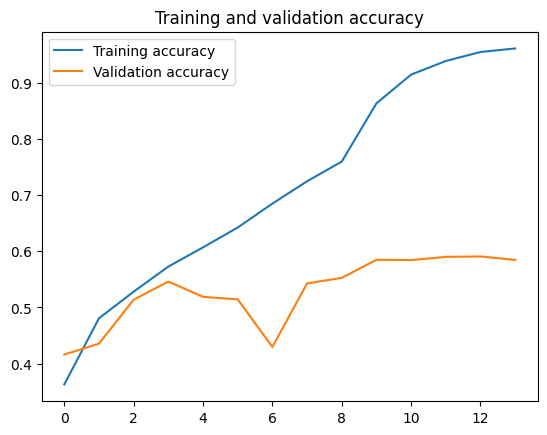

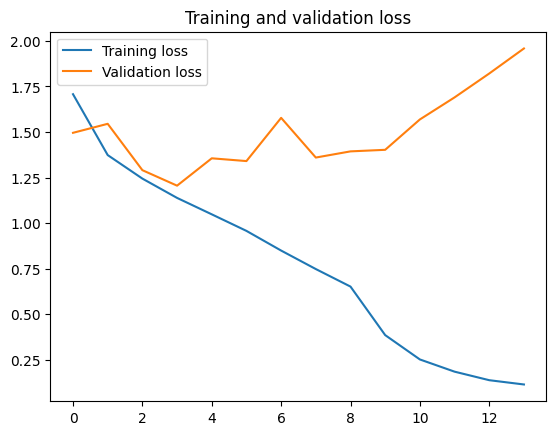

In [24]:
def plot_training(history):
    # Retrieve a list of accuracy results on training and test data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Retrieve a list of list results on training and test data
    # sets for each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
plot_training(history)